In [ ]:
# setup correct PyTorch version
!pip install -U torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
import torch 

# Download the code
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
%cd stylegan2-ada-pytorch

# install other dependencies 
!pip install ninja

print('PyTorch version: {}'.format(torch.__version__) )
!nvidia-smi -L
print('GPU Identified at: {}'.format(torch.cuda.get_device_name()))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 97.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 34.9 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.1+cu118
    Uninstalling torchvision-0.15.1+cu118:
      Successfully uninstalled torchvision-0.15.1+cu118
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.0.1+cu118
    Uninstalling torchaudio-2.0.1+cu118:
      Successfully uninstalled torchaudio-2.0.1+cu118
ERROR: pip's dependency resolver does not current

In [ ]:
# Download the model
import argparse
import numpy as np
import PIL.Image
import dnnlib
import re
import sys
from io import BytesIO
import IPython.display
import numpy as np
from math import ceil
from PIL import Image, ImageDraw
import imageio
import matplotlib.pyplot as plt
import legacy
import cv2
import torch
from tqdm.autonotebook import tqdm

device = torch.device('cuda')

# Choose between these pretrained models
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/afhqcat.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/afhqdog.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/afhqwild.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/brecahad.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/cifar10.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metfaces.pkl

network_pkl = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"

# If downloads fails, you can try downloading manually and uploading to the session directly 
# network_pkl = "/content/ffhq.pkl"

print('Loading networks from "%s"...' % network_pkl)
with dnnlib.util.open_url(network_pkl) as f:
  G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...


In [ ]:
# Useful utility functions...

# Generates an image from a style vector.
def generate_image_from_style(dlatent, noise_mode='none'):

  if len(dlatent.shape) == 1: 
    dlatent = dlatent.unsqueeze(0)
    
  row_images = G.synthesis(dlatent, noise_mode=noise_mode)
  row_images = (row_images.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  return row_images[0].cpu().numpy()    

# Converts a noise vector z to a style vector w.
def convert_z_to_w(latent, truncation_psi=0.7, truncation_cutoff=9, class_idx=None):
  label = torch.zeros([1, G.c_dim], device=device)   
  if G.c_dim != 0:
    if class_idx is None:
      RuntimeError('Must specify class label with class_idx when using a conditional network')
    label[:, class_idx] = 1
  else:
    if class_idx is not None:
      print(f'warning: class_idx={class_idx} ignored when running on an unconditional network')
  return G.mapping(latent, label, truncation_psi=truncation_psi, truncation_cutoff=truncation_cutoff)

In [ ]:
# download 
!gdown "1NcRdVWicD1pS1X_XN3MfBrXQwffhB3wF" -O "../"

Downloading...
From: https://drive.google.com/uc?id=1NcRdVWicD1pS1X_XN3MfBrXQwffhB3wF
To: /content/ffhq-gender,age,pitch,roll,yaw.weights
100% 94.4M/94.4M [00:00<00:00, 261MB/s]


In [ ]:
from torchvision import models as tv
cnn = tv.resnet50(pretrained=False, progress=True, num_classes = 5)
cnn.eval()
cnn.load_state_dict(torch.load('../ffhq-gender,age,pitch,roll,yaw.weights', map_location=lambda storage, loc: storage))

# Returns whether face is perceptually female (True) or male (False) given
# an input image of shape (H, W, 3).
def face_is_female(img):
  im = np.asarray(img)/255.0
  im = cv2.resize(im, (256, 256))
  im = np.expand_dims(np.transpose(im, (2,0,1)), 0)
  im = torch.FloatTensor(im)
  logits = cnn(im)[0, 0]
  return (logits < 0.5).numpy()

In [ ]:
from tqdm import tqdm
"""
:- Sample 1000 random z vectors
:- Then convert them to style vectors w
:- Get their corresponding perceived genders
"""
styles, genders = [],[]
for idx in tqdm(range(0,1000)):
  z = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device) # get random z vector
  w = convert_z_to_w(z, truncation_psi=0.7, truncation_cutoff=9) # convert to style vector
  img = generate_image_from_style(w) # generate image from w
  gen = face_is_female(img)  # classify image with cnn classifier
  # save data
  styles.append(w.cpu().detach().numpy()); genders.append(gen);

100%|██████████| 1000/1000 [04:49<00:00,  3.46it/s]


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

wX = []
for idx in range(len(styles)):
  wX.append(styles[idx].reshape((styles[0].shape[0]*styles[0].shape[1]*styles[0].shape[2])))

In [ ]:
X, y = make_classification(n_features=4, random_state=0)
print(np.array(wX).shape, X.shape)
print(np.array(genders).shape, y.shape)

(1000, 9216) (100, 4)
(1000,) (100,)


In [ ]:
clf = make_pipeline(LinearSVC(random_state=0, tol=1e-5))
clf.fit(wX, genders)

Pipeline(steps=[('linearsvc', LinearSVC(random_state=0, tol=1e-05))])

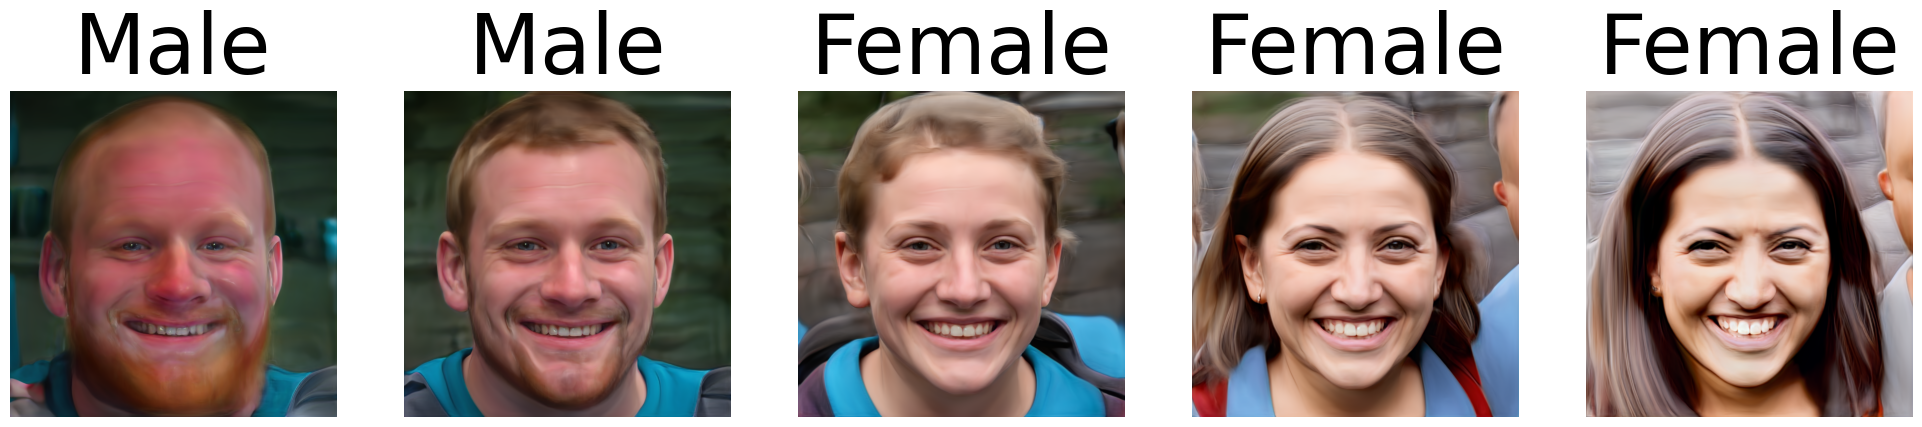

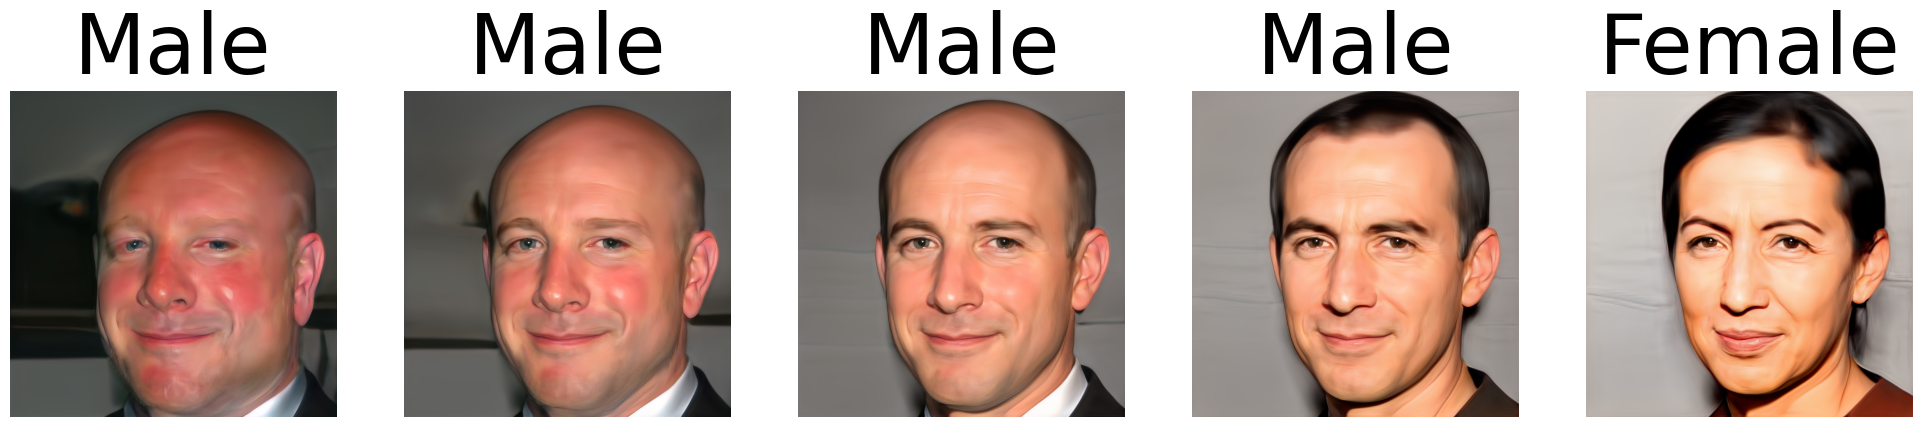

In [ ]:
import random

fig, rows, columns = plt.figure(figsize=(50, 50)), 10,10

old_w = styles[100]; v = clf.named_steps['linearsvc'].coef_[0].reshape((styles[0].shape))
alpha = -30
for idx in range(5):
  new_w = old_w + alpha * v
  img = generate_image_from_style(torch.from_numpy(new_w).to('cuda'))
  fig.add_subplot(rows, columns, idx+1); plt.imshow(img,cmap='gray'); plt.axis('off')
  # Female classifier as title
  if(face_is_female(img) == False):
    plt.title('Male', fontsize="60")
  else:
    plt.title('Female', fontsize="60")

  alpha += 15

old_w = styles[75];
fig, rows, columns = plt.figure(figsize=(50, 50)), 10,10
alpha = -30
for idx in range(5):
  new_w = old_w + alpha * v
  img = generate_image_from_style(torch.from_numpy(new_w).to('cuda'))
  fig.add_subplot(rows, columns, idx+1); plt.imshow(img,cmap='gray'); plt.axis('off')
  # Female classifier as title
  if(face_is_female(img) == False):
    plt.title('Male', fontsize="60")
  else:
    plt.title('Female', fontsize="60")

  alpha += 15

# Problem 2: CLIP

In [ ]:
! pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-qqs4cu1m
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-qqs4cu1m
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.2 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369398 sha256=77b09291744e9dda0afee69a0fa92d0aacb955a07c0aac9508e95870064cde43
  Stored in directory: /tmp/pip-ephem-wheel-cache-rtmrw1_u/wheels/c8/e4/e1/11374c111387672fc2068dfbe0d4b424cb9cdd1b2e184a71b5
Successfully built clip


In [ ]:
import clip
import numpy as np

model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 124MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

cifar = np.load('/content/drive/MyDrive/CIFAR.npz') # Replace with your path to CIFAR.
X,y,label_names = cifar['X'], cifar['y']*1.0, cifar['label_names']
print(label_names)

Mounted at /content/drive
['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


In [ ]:
from tqdm import tqdm
captions = [f"An image of a {label}" for label in label_names] 
output, ground_truths  = [], []
# Iterate over all test examples.
for i in tqdm(range(50000, 60000)): 
  image = preprocess(Image.fromarray(np.uint8(X[i,...]))).unsqueeze(0).to('cuda')
  text = clip.tokenize(captions).to(device)
  ground_truths.append(captions[int(y[i])])
  with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    output.append(captions[probs.argmax()])
    
correct = 0
# compute overall accuracy
for idx in range(len(ground_truths)): 
  if ground_truths[idx] == output[idx]:
    correct += 1
acc = 100*(correct/len(ground_truths))
print(f'\nOverall Accuracy: {acc}%')



100%|██████████| 10000/10000 [07:19<00:00, 22.75it/s]

Overall Accuracy: 89.05999999999999%


In [ ]:
acc = 100*(correct/len(ground_truths))
print(f'\nOverall Accuracy: {acc}%')


Overall Accuracy: 89.05999999999999%


In [ ]:
from tqdm import tqdm
captions = [f"An image of a {label}" for label in label_names] 
output, ground_truths  = [], []
# Iterate over all test examples.
for i in tqdm(range(50000, 60000)): 
  image = preprocess(Image.fromarray(np.uint8(X[i,...]))).unsqueeze(0).to('cuda')
  text = clip.tokenize(captions).to(device)
  ground_truths.append(captions[int(y[i])])
  with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    output.append(captions[probs.argmax()])
    
correct = 0
# compute overall accuracy
for idx in range(len(ground_truths)): 
  if ground_truths[idx] == output[idx]:
    correct += 1
acc = 100*(correct/len(ground_truths))
print(f'\nOverall Accuracy: {acc}%')

## b. Engineer the caption prompts to try to obtain better accuracy. To do so, give a set of possible captions per class instead of just one.

In [ ]:
from tqdm import tqdm

captions1 = [f"A photo of a {label}" for label in label_names] 
captions2 = [f"A bad photo of a {label}" for label in label_names] 
captions3 = [f"An imagery of {label}" for label in label_names] 
captions4 = [f"A large {label}" for label in label_names] 
captions5 = [f"A small {label}" for label in label_names] 
captions = captions1 + captions2 + captions3 + captions4 + captions5
output, gt1, gt2, gt3, gt4, gt5  = [], [], [], [], [], []

# Iterate over all test examples.
for i in tqdm(range(50000, 60000)): 
  image = preprocess(Image.fromarray(np.uint8(X[i,...]))).unsqueeze(0).to('cuda')
  text = clip.tokenize(captions).to(device)
  # load correct ground truths
  gt1.append(captions1[int(y[i])]); gt2.append(captions2[int(y[i])]);
  gt3.append(captions3[int(y[i])]); gt4.append(captions4[int(y[i])]);
  gt5.append(captions5[int(y[i])]);
  # get results
  with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    output.append(captions[probs.argmax()])
    
correct = 0
# compute overall accuracy
for idx in range(len(gt1)): 
  if output[idx] == gt1[idx] or output[idx] == gt2[idx] or output[idx] == gt3[idx] or output[idx] == gt4[idx] or output[idx] == gt5[idx]:
    correct += 1
acc = 100*(correct/len(gt1))
print(f'\nOverall Accuracy: {acc}%')

100%|██████████| 10000/10000 [21:11<00:00,  7.86it/s]


Overall Accuracy: 89.7%
